#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the IMD dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [0]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

Let's also get the word indexs (word to word-id)

*   List item
*   List item



In [0]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [0]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [0]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Since the model performs a binary classification task, we use cross-entropy as loss.

In [0]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 26s 131ms/step - loss: 0.6682 - accuracy: 0.5799 - val_loss: 0.5615 - val_accuracy: 0.7619
Epoch 2/10
196/196 [==============================] - 26s 134ms/step - loss: 0.4405 - accuracy: 0.8071 - val_loss: 0.4009 - val_accuracy: 0.8301
Epoch 3/10
196/196 [==============================] - 27s 140ms/step - loss: 0.2976 - accuracy: 0.8825 - val_loss: 0.3482 - val_accuracy: 0.8610
Epoch 4/10
196/196 [==============================] - 25s 127ms/step - loss: 0.2230 - accuracy: 0.9159 - val_loss: 0.3530 - val_accuracy: 0.8646
Epoch 5/10
196/196 [==============================] - 23s 115ms/step - loss: 0.1882 - accuracy: 0.9315 - val_loss: 0.3716 - val_accuracy: 0.8602
Epoch 6/10
196/196 [==============================] - 27s 137ms/step - loss: 0.1728 - accuracy: 0.9356 - val_loss: 0.3712 - val_accuracy: 0.8450
Epoch 7/10
196/196 [==============================] - 27s 139ms/step - loss: 0.1312 - accuracy: 0.9543 - val_loss: 0.3998 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 9s - loss: 0.5812 - accuracy: 0.8101
accuracy: 81.01%


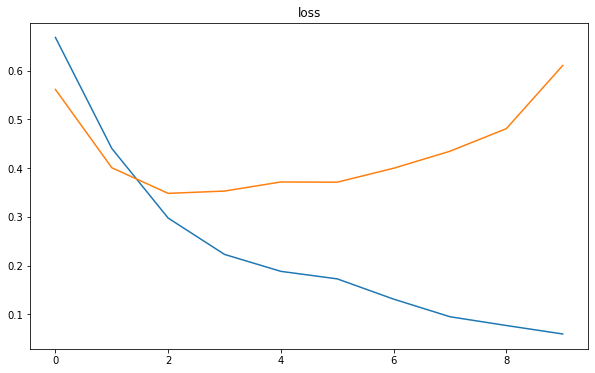

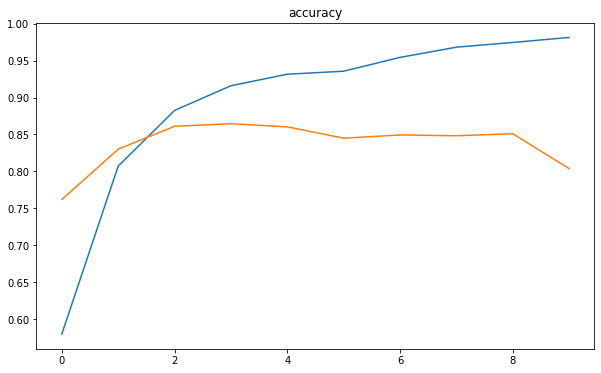

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#Remark: 
To run the code in a short time I connect to a local runtime using Jupyter. This allows you to execute code on mine local hardware and have access to mine local file system. 

##Exercise 4.1: LSTM and GRU
**To complete**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**To complete**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion below*

For exercise 4.1 I wanted to compare five important points that together determine the efficiency of a good Deep Learning model. These 5 points are:

1. Accuracy 
2. Loss 
3. Overfitting
4. Computational Costs
5. Fair Comparison

Obviously we will never find the best model, as with everything, especially in the field of scientific research. But you can find a good approximation that can give satisfactory results, trying to be balanced between the points listed.
#LSTM Solution

First of all, I have changed the SimpleRNN layer of the previous exercise with a LSTM layer, also modifying the number of units to match the parameter's number.  

In particular, I have 101,409 parameters using SimpleRNN with 32 units vs 101,415 parameters using LSTM with 14 units.



In [13]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

print('\nCreate a model with LSTM\n')
print('\nBuild model...\n')
model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(14))
model_lstm.add(keras.layers.Dense(1, activation="sigmoid"))
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("\n***Summary of LSTM Model***\n")
model_lstm.summary()


Create a model with LSTM


Build model...


***Summary of LSTM Model***

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________



Train...

Epoch 1/10
196/196 [==============================] - 48s 244ms/step - loss: 0.5727 - accuracy: 0.7003 - val_loss: 0.4081 - val_accuracy: 0.8351
Epoch 2/10
196/196 [==============================] - 46s 234ms/step - loss: 0.3090 - accuracy: 0.8803 - val_loss: 0.3253 - val_accuracy: 0.8682
Epoch 3/10
196/196 [==============================] - 45s 228ms/step - loss: 0.2310 - accuracy: 0.9161 - val_loss: 0.3145 - val_accuracy: 0.8694
Epoch 4/10
196/196 [==============================] - 45s 228ms/step - loss: 0.1852 - accuracy: 0.9354 - val_loss: 0.3461 - val_accuracy: 0.8702
Epoch 5/10
196/196 [==============================] - 47s 242ms/step - loss: 0.1566 - accuracy: 0.9472 - val_loss: 0.3256 - val_accuracy: 0.8716
Epoch 6/10
196/196 [==============================] - 44s 225ms/step - loss: 0.1263 - accuracy: 0.9598 - val_loss: 0.4074 - val_accuracy: 0.8634
Epoch 7/10
196/196 [==============================] - 43s 220ms/step - loss: 0.1072 - accuracy: 0.9682 - val_loss: 0.39

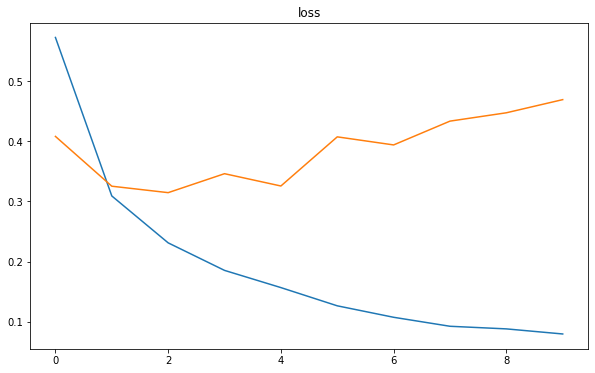

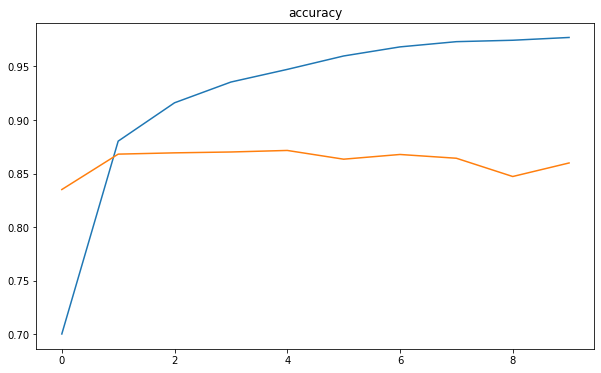

In [14]:
print('\nTrain...\n')
history_lstm = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


print("\nLoss and Accuracy Graphs for LSTM\n")
plot_loss(history_lstm)
plot_accuracy(history_lstm)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

#GRU Solution

In this part, I have changed the SimpleRNN layer of the previous exercise with a GRU layer, also modifying the number of units to match the parameter's number. 

In particular, I have 101,409 parameters using SimpleRNN with 32 units vs 101,361 parameters using GRU with 16 units.


In [15]:
print('\nCreate a model with GRU\n')
print('\nBuild model...\n')
model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(1, activation="sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("\n***Summary of GRU Model***\n")
model_gru.summary()


Create a model with GRU


Build model...


***Summary of GRU Model***

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________



Train...

Epoch 1/10
196/196 [==============================] - 52s 264ms/step - loss: 0.5706 - accuracy: 0.6832 - val_loss: 0.3750 - val_accuracy: 0.8373
Epoch 2/10
196/196 [==============================] - 46s 236ms/step - loss: 0.3002 - accuracy: 0.8773 - val_loss: 0.3307 - val_accuracy: 0.8579
Epoch 3/10
196/196 [==============================] - 33s 166ms/step - loss: 0.2241 - accuracy: 0.9155 - val_loss: 0.3263 - val_accuracy: 0.8656
Epoch 4/10
196/196 [==============================] - 30s 154ms/step - loss: 0.1837 - accuracy: 0.9352 - val_loss: 0.3422 - val_accuracy: 0.8663
Epoch 5/10
196/196 [==============================] - 31s 156ms/step - loss: 0.1590 - accuracy: 0.9447 - val_loss: 0.3566 - val_accuracy: 0.8563
Epoch 6/10
196/196 [==============================] - 30s 153ms/step - loss: 0.1385 - accuracy: 0.9539 - val_loss: 0.4020 - val_accuracy: 0.8576
Epoch 7/10
196/196 [==============================] - 30s 154ms/step - loss: 0.1274 - accuracy: 0.9574 - val_loss: 0.43

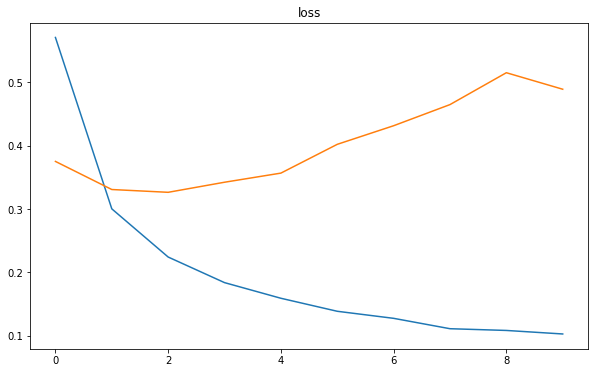

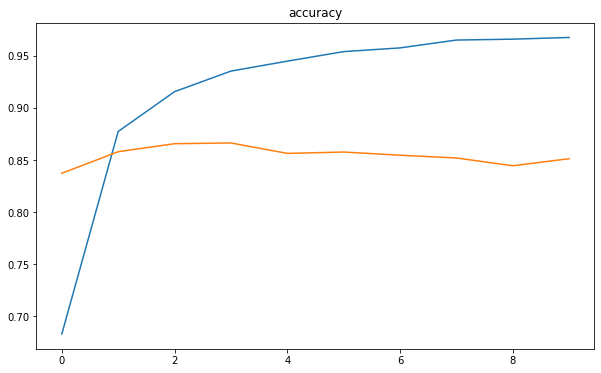

In [16]:
print('\nTrain...\n')
history_gru= model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

print("\nLoss and Accuracy Graphs for GRU\n")
plot_loss(history_gru)
plot_accuracy(history_gru)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

#Discussion about Exercise 4.1

All 3 models have more or less the same number of parameters. I report you the final outcomes:

##  1- Simple RNN model with 32 units

1.  Accuracy: 81.01%

2.  Loss:  0.5812

3.  Overfitting: Yes, there is overfitting

4.  Computational Costs in training set: Completion time of each epoch is between [25,27] seconds 

5.  Fair comparison: Yes with other models
 
##   2- LSTM model with 14 units

1.  Accuracy: 86.02%

2.  Loss: 0.4564

3.  Overfitting: Yes, there is overfitting

4.  Computational Costs in training set: Completion time of each epoch is between [43,47] seconds,except the first epoch where the completion time lasted 31 seconds

5.  Fair comparison: Yes with other models
 

##   3- GRU model with 16 units

1.  Accuracy: 85.06%

2.  Loss: 0.4749

3.  Overfitting: Yes, there is overfitting

4.  Computational Costs in training set:  Completion time of each epoch is between [30,33] seconds, except the first epoch where the completion time lasted 35 seconds

5.  Fair comparison:  Yes with other models
 
********************************************************************************************************************************************************************************************************************************************************************************************************************************
After to pick up these info from the 3 models,I can notice that, the model that has the best accuracy and the lowest loss is the LSTM model, with more or less the same number of parameters. However, the computational cost is high than Simple RNN model. 

If I consider the GRU model, with, more or less, the same number of parameters, the accuracy is a lower hair than the LSTM model with a consequent slight increase in loss. But the computational cost is a  lower than the LSTM model. For each epoch there is a difference of 13 seconds as average.

So, both LSTM and GRU model, the computation cost in the training set is worst than Simple RNN. In order to improve this point, I added before LSTM layers and before GRU layer a convolutional 1D Layer, always with more or less the same number of  parameters.




I report you only the line codes:

model_lstm.add(keras.layers.Conv1D(filters=16,kernel_size=3,padding='same' activation="relu"))

model_lstm.add(keras.layers.MaxPooling1D(5))
********************************************************************************************************************************************************************************************************************************************************************************************************************************



##   4- LSTM model with 9 units and convolutional 1D layer + Maxpooling1D



1.  Accuracy: 85,48%

2.  Loss: 0.5299

3.  Overfitting: Yes, there is overfitting

4.  Computational Costs in training set: Completion time of each epoch is 7 seconds.

5.  Fair comparison: Yes with other models. It presents 101,442 vs 101.409 of Simple RNN 

##   5- GRU model with 10 units and convolutional 1D layer + Maxpooling1D

1.  Accuracy: 86.02%

2.  Loss: 0.5414

3.  Overfitting: Yes, there is overfitting

4.  Computational Costs in training set: Completion time of each epoch is between [7,8] seconds.

5.  Fair comparison: Yes with other models. It presents 101,347 vs 101.409 of Simple RNN 

### Here there are the graphs of LSTM models with convolutional 1D layer
Model Summary:

<img src="https://user-images.githubusercontent.com/53294518/81937968-9013d880-95f4-11ea-8573-b0e6a662bf27.png" width="500"/>


Loss:

<img src="https://user-images.githubusercontent.com/53294518/81947881-5ac1b780-9601-11ea-91a3-e1c52ef95ced.png" width="500"/>


Accuracy:

<img src="https://user-images.githubusercontent.com/53294518/81947997-7d53d080-9601-11ea-8cc5-6b2df2566362.png" width="500"/>

### Here there are the graphs of GRU models with convolutional 1D layer
Model Summary:

<img src="https://user-images.githubusercontent.com/53294518/81938090-bc2f5980-95f4-11ea-8356-4d023cb98652.png" width="500"/>


Loss:

<img src="https://user-images.githubusercontent.com/53294518/81948051-93fa2780-9601-11ea-8bac-d5b632739ffd.png" width="500"/>



Accuracy:

<img src="https://user-images.githubusercontent.com/53294518/81948114-aaa07e80-9601-11ea-8ed1-8b1a32463972.png" width="500"/>



********************************************************************************************************************************************************************************************************************************************************************************************************************************
#Final Remarks

Convolutive networks are very well suited to computerized vision problems, thanks to their ability to extract characteristics from local input elements and ensure modularity of representation and efficient use of data. Such convets are also interesting in sequence processing. Time can be treated as a spatial dimension, such as the height or width of a 2D image. They are interesting because the computational costs are lower. 

In fact I noticed that for each epoch the computational cost varies between 7 and 8 seconds for both the LSTM model and the GRU model. If we take the two LSTM models we notice a difference of about 38.1 seconds per epoch. If we take the two GRU models the difference in time is 24 seconds per epoch.

Also if we always check the two LSTM models the accuracy is slightly lower in the model with the application of Conv1D of about 0.54 and a slightly higher loss of 0.0735.

For the two GRU models the accuracy difference is 0.96, in favor of the GRU with Conv1D layer.

For the loss, the difference between the two models is 0.0675, where the GRU's solution with Conv1D. presents loss slightly higher than other.





```
# This is formatted as code
```

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [17]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 30s 191ms/step - loss: 0.6359 - accuracy: 0.6456 - val_loss: 0.4397 - val_accuracy: 0.8150
Epoch 2/10
157/157 [==============================] - 30s 189ms/step - loss: 0.3199 - accuracy: 0.8680 - val_loss: 0.3195 - val_accuracy: 0.8654
Epoch 3/10
157/157 [==============================] - 32s 205ms/step - loss: 0.2201 - ac

391/391 - 11s - loss: 0.5338 - accuracy: 0.8554
accuracy: 85.54%


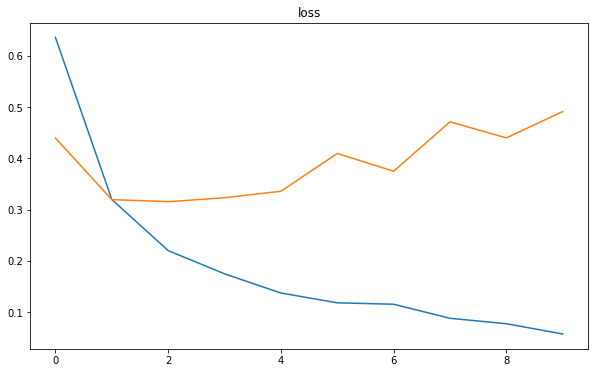

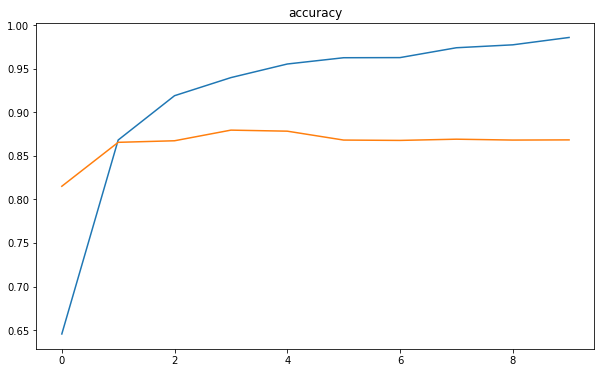

In [18]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##Exercise 4.2: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**To complete**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue. Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion below*

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 24s 301ms/step - loss: 0.6930 - accuracy: 0.5046 - val_loss: 0

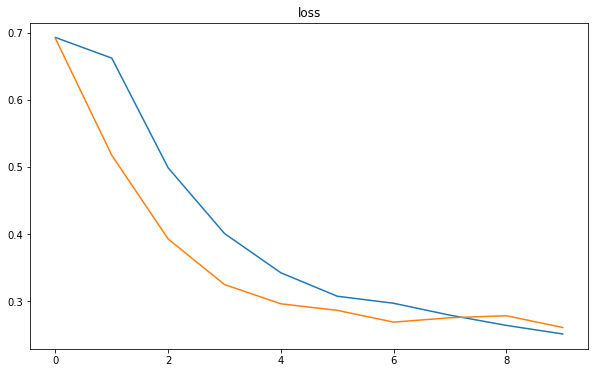

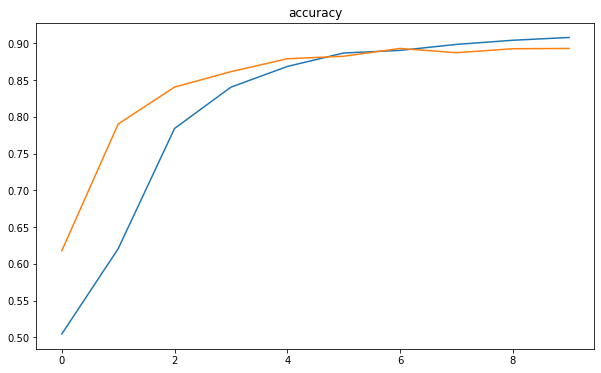

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model_bidirectional1 = keras.models.Sequential()
model_bidirectional1.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional1.add(keras.layers.Dropout(0.8))
model_bidirectional1.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional1.add(keras.layers.Dropout(0.8))
model_bidirectional1.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional1.summary()

history = model_bidirectional1.fit(X_train_trim, y_train,
                    epochs=10, batch_size=256, validation_split=0.2)

plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional1.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional1.metrics_names[1], scores[1]*100))

#Exercise 4.2: Discussion: Bidirectional LSTM model with Dropout

Just adding two layers with a Dropout probability of 80%, the model has significantly improved in performance, reaching an accuracy of 88.81% and a loss of 0.2726. To improve the performance I put the batch_size at 256.
The accuracy of the latter model has improved by about 3.27%. 

An important fact is that computational costs are interesting. Indeed, regarding the bidirectional LSTM model without Dropout, completion time, in the training, for each epoch, is between [29,32] seconds, while in the other is [20,23] seconds. An improvement in time is also dictated by the increase in the number of batch_size

Finally, the goal of this exercise is the overfitting. As can be seen from the graphs above, these decisions proved to be a valid adaptation to the pre-existing model, which tended to overfitting too early.